# Characterisation of Benchmark Datasets

In [1]:
import os
wd = os.getcwd()

utils_nb = os.path.join(wd, "0_Utils.ipynb")
%run {utils_nb}

In [1]:
import warnings
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from typing import Callable
warnings.filterwarnings("ignore")

def standardise_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return Chem.MolToSmiles(mol)
    else:
        return None

def load_dataset(name: str, path: str, smiles_col: str, affinity_col: str, affinity_conversion: Callable) -> pd.DataFrame:
    # Load data
    data = pd.read_csv(path)

    # Convert affinity to pXC50 scale
    data['affinity'] = affinity_conversion(data[affinity_col])

    # Standardise column names and deduplicate
    data = data.rename(columns={smiles_col: 'SMILES'})
    data["SMILES"] = data.SMILES.apply(standardise_smiles)

    # Remove None values after standardisation
    data = data.dropna(subset=["SMILES"])

    # Find duplicates and replace with mean
    data = data.groupby('SMILES').agg({'affinity': 'mean'}).reset_index()
    data["target"] = name

    # Calculate top 2% and 5% active compounds
    data['top_2p'] = False
    data.loc[data['affinity'].nlargest(round(len(data) * 0.02)).index, 'top_2p'] = True
    data["top_5p"] = False
    data.loc[data['affinity'].nlargest(round(len(data) * 0.05)).index, 'top_5p'] = True

    # Featurise using RDKit (ECFP8 with radius=4)
    def get_ecfp8(smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=4, nBits=4096)
            return np.array(ecfp)
        else:
            return np.nan

    data["fps"] = data.SMILES.apply(get_ecfp8)

    return data


In [2]:
tyk2_data = load_dataset("TYK2", "data/Tyk2_dataset.csv", "Smiles", "dG", lambda x: -(x-47.778) / (8.314e-3 * 298.15 * np.log(10)))
#usp7_data = load_dataset("USP7", "data/usp.csv", "canonical smi", "IC50", lambda x: -np.log10(x) + 9)
d2r_data = load_dataset("D2R", "data/Dopamine D2 receptor.csv", 'canonical_smiles', 'pKi', lambda x: x)
#mpro_data = load_dataset("Mpro", "data/Mpro.csv", 'SMILES', 'pIC50', lambda x: x)

# all_data = pd.concat([tyk2_data, usp7_data, d2r_data, mpro_data]).reset_index(drop=True)
# all_data

In [3]:
tyk2_data

,SMILES,affinity,target,top_2p,top_5p,fps
0,C=Cc1cc(Cl)c(C(=O)Nc2cc(N)ncc2F)c(Cl)c1,5.608397,TYK2,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,C=Cc1cc(Cl)c(C(=O)Nc2cc(NC(=O)C3CC(=O)C3)ncc2F...,7.972925,TYK2,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C=Cc1cc(Cl)c(C(=O)Nc2cc(NC(=O)C3CC(O)C3)ncc2F)...,6.731267,TYK2,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,C=Cc1cc(Cl)c(C(=O)Nc2cc(NC(=O)C3CC3C#N)ncc2F)c...,7.653882,TYK2,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,C=Cc1cc(Cl)c(C(=O)Nc2cc(NC(=O)C3CC3C(=O)NC)ncc...,7.262305,TYK2,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
9992,O=Cc1cc(Cl)c(C(=O)Nc2ccnc(NC(=O)NC3CC3)c2)c(Cl)c1,7.859394,TYK2,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9993,O=Cc1cc(Cl)c(C(=O)Nc2ccnc(NC(=O)NC3CCC3)c2)c(C...,7.902844,TYK2,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9994,O=Cc1cc(Cl)c(C(=O)Nc2ccnc(NC(=O)Nc3ccccn3)c2)c...,7.839421,TYK2,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9995,O=Cc1cc(Cl)c(C(=O)Nc2ccnc(NC(=O)Nc3cccnc3)c2)c...,8.473302,TYK2,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [5]:
tyk2_data=pd.read_csv("data/Tyk2_dataset.csv")

In [3]:
pd.read_csv("data/Dopamine D2 receptor.csv")

,canonical_smiles,Ki,pKi
0,COc1ccc(N/C(S)=N/CCCn2ccnc2)cc1,700.00,6.154902
1,CCOc1ccc(N/C(S)=N/CCCn2ccnc2)cc1,890.00,6.050610
2,S=C(NCCCn1ccnc1)Nc1ccc(OCc2ccccc2)cc1,970.00,6.013228
3,CSc1ccc(N/C(S)=N/CCCn2ccnc2)cc1,1660.00,5.779892
4,CC(=O)c1ccc(N/C(S)=N/CCCn2ccnc2)cc1,1790.00,5.747147
...,...,...,...
4116,COc1ccccc1N1CCN(Cc2cn3ccccc3n2)CC1,3900.00,5.408935
4117,Clc1ccc(N2CCN(Cc3cn4ccccc4n3)CC2)cc1Cl,1700.00,5.769551
4118,Fc1ccc(N2CCN(Cc3cn4ccccc4n3)CC2)cc1,3100.00,5.508638
4119,N#Cc1ccc2[nH]c(CN3CCN(c4ccc(F)cc4)CC3)cc2c1,1.00,9.000000


<Axes: xlabel='affinity', ylabel='Density'>

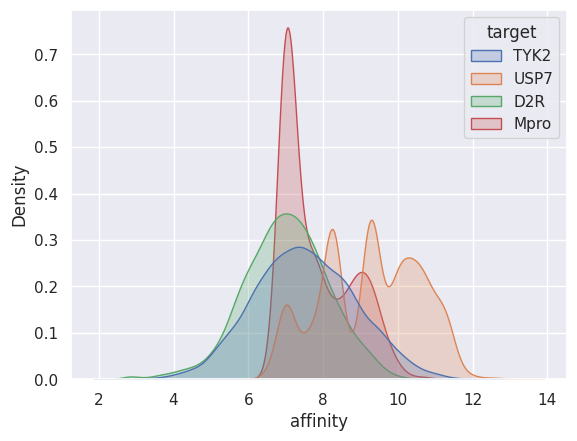

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.kdeplot(data=all_data[all_data.affinity > 2.5], x="affinity", hue="target", fill=True, common_norm=False)

In [5]:
all_data

,SMILES,affinity,target,top_2p,top_5p,fps
0,C=Cc1cc(c(c(c1)Cl)C(=O)Nc2cc(ncc2F)N)Cl,5.608397,TYK2,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,C=Cc1cc(c(c(c1)Cl)C(=O)Nc2cc(ncc2F)NC(=O)C3CC(...,7.972925,TYK2,False,False,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,C=Cc1cc(c(c(c1)Cl)C(=O)Nc2cc(ncc2F)NC(=O)C3CC(...,6.731267,TYK2,False,False,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,C=Cc1cc(c(c(c1)Cl)C(=O)Nc2cc(ncc2F)NC(=O)C3CC3...,7.653882,TYK2,False,False,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,C=Cc1cc(c(c(c1)Cl)C(=O)Nc2cc(ncc2F)NC(=O)C3CC3...,6.562022,TYK2,False,False,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
17694,c1ccn2cnc(c2c1)NC(=O)Cc3cccc(c3)Cl,7.004365,Mpro,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
17695,c1ccnc(c1)c2c(c[nH]n2)NC(=O)c3cccc4n3ccn4,7.004365,Mpro,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
17696,c1cnc(nc1Cl)C#N,7.004365,Mpro,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
17697,c1cscc1CN2CCN(CC2)C(=O)CCl,8.944124,Mpro,False,False,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [6]:
all_data = all_data.rename(columns={"affinity": "Affinity"})

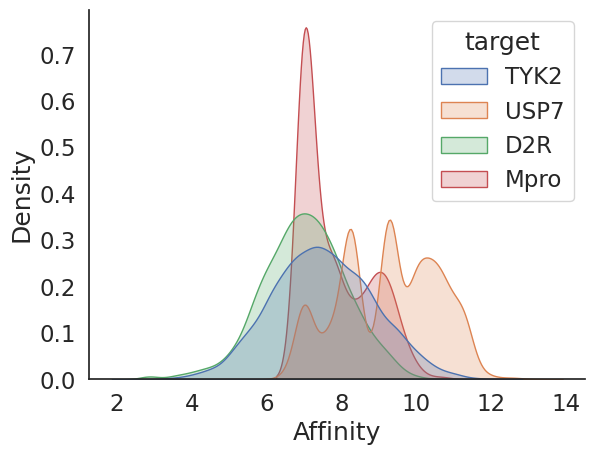

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style('white')
sns.set_context("notebook", font_scale=1.5)

sns.kdeplot(data=all_data[all_data.Affinity > 2.5], x="Affinity", hue="target", fill=True, common_norm=False)
sns.despine()
plt.show()

<Axes: xlabel='Affinity', ylabel='Density'>

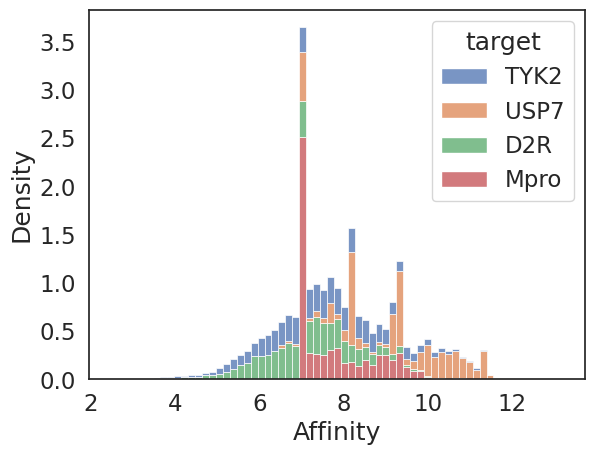

In [8]:
sns.histplot(data=all_data[all_data.Affinity > 2.5], x="Affinity", hue="target", multiple="stack", stat = "density", common_norm=False)

In [9]:
!pip show umap-learn | grep Version

Version: 0.5.2


In [ ]:
import umap
print(umap.__version__)


0.5.2


In [11]:
import pickle

from exs.ale.analysis.dim_reduction import UMAP
from exs.ale.analysis.plot_chemical_space import plot_chemical_space

for target_name in ["TYK2", "USP7", "Mpro", "D2R"]:

    target_data = all_data[all_data.target == target_name].reset_index(drop=True)
    target_data = target_data.sort_values(by="SMILES").reset_index(drop=True)

    umap = UMAP(fp_col="fps", plot=False, umap_kws={"random_state": 1})
    umap.read_input(df_dim_reduction=target_data)
    umap.run()
    feature_map = umap.outputs["feature_map"]

    with open(f"data/feature_maps/{target_name}.pkl", "wb") as fmap_file:
        pickle.dump(feature_map, fmap_file)
    

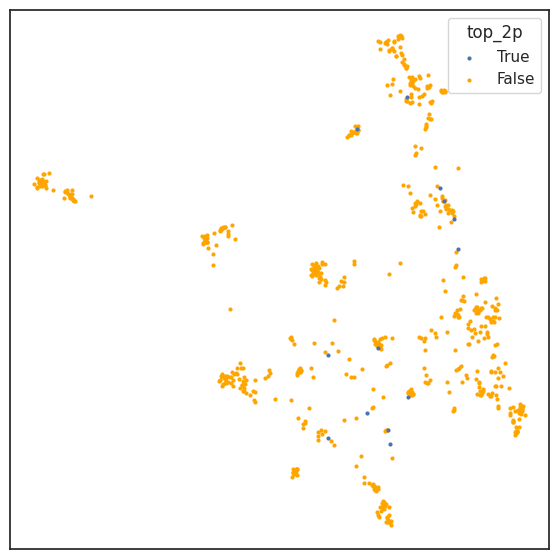

In [8]:
import pickle
from exs.ale.analysis.plot_chemical_space import plot_chemical_space
# for target_name in ["TYK2", "USP7", "Mpro", "D2R"]:
for target_name in ["Mpro"]:

    target_data = all_data[all_data.target == target_name].reset_index(drop=True)
    target_data = target_data.sort_values(by="SMILES").reset_index(drop=True)

    with open(f"data/feature_maps/{target_name}.pkl", "rb") as fmap_file:
        feature_map = pickle.load(fmap_file)

#     plot_chemical_space(target_data, feature_map, heatmap_col="Affinity",size=7,markersize=9)
    plot_chemical_space(target_data, feature_map, set_col="top_2p",size=7,markersize=9, set_colors={True: "b", False: "orange"}, zorder={True: 2, False: 1})

## Centroids

In [4]:
from typing import Any, Dict, List

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


def _check_for_errors(
    df: pd.DataFrame, heatmap_col: str, set_col: str, set_as_heatmap: str
) -> None:
    """Helper function to check if provided arguments are compatible

    Args:
        df (pd.DataFrame): Data to plot
        heatmap_col (str): Name of column to be shown on a heatmap
        set_col (str): Name of column which splits data into sets to be plotted with different markers
        set_as_heatmap (str): Name of set (one in set_col.unique) to be plotted on a heatmap
    """
    if heatmap_col and (heatmap_col not in df.columns):
        raise Exception(f"Data frame has no column named {heatmap_col}!")

    if set_col and (set_col not in df.columns):
        raise Exception(f"Data frame has no column named {set_col}!")

    if set_as_heatmap and not (heatmap_col and set_col):
        raise Exception("Must provide both heatmap_col and set_col with set_as_heatmap")


def _subset_dict(dict_to_subset: Dict[str, Any], sets: List[str]) -> Dict[str, Any]:
    """Subset dict to only include keys specified as sets

    Args:
        dict (Dict[str, Any]): Dict as provided to input
        sets (List[str]): List of sets to include

    Returns:
        Dict[str, Any]: dict with filtered keys
    """
    if dict_to_subset:
        return {k: v for (k, v) in dict_to_subset.items() if k in sets}
    else:
        return {}


def plot_chemical_space(
    df: pd.DataFrame,
    feature_map: np.ndarray,
    heatmap_col: str = None,
    set_col: str = None,
    set_as_heatmap: str = None,
    indices: List = None,
    size: int = 7,
    markersize: int = 9,
    set_markersize: int = 9,
    cmap: str = "copper_r",
    ax: Any = None,
    set_colors: Dict[str, Any] = {},
    set_markers: Dict[str, str] = {},
    set_order: List[str] = [],
    zorder: Dict[str, int] = {},
    legend: bool = True,
    labels: Dict[str, Any] = {},
    xlabel: str = '',
    ylabel: str = '',
) -> Any:
    """Generic function for making TSNE/UMAP plots of all kinds

    Args:
        df (pd.DataFrame): Dataframe containing compounds as rows
        feature_map (np.ndarray): Output from TSNE or UMAP
        heatmap_col (str, optional): Column to be shown on a heatmap. Defaults to None.
        set_col (str, optional): Column splitting data to sets, which are plotted with different markers.
           Defaults to None.
        set_as_heatmap (str, optional): Set (from data.set_col.unique) to be shown on a heatmap. Defaults to None.
        indices (List, optional): Subset of data to plot (if None, plot everything). Defaults to None.
        size (int, optional): Figure size. Defaults to 10.
        markersize (int, optional): Marker size (heatmap). Defaults to 10.
        set_markersize (int, optional): Markersize (monochrome sets). Defaults to 10.
        cmap (str, optional): Color map for heatmap. Defaults to "Reds".
        ax (Any, optional): Axis object to plot this in, if part of a bigger subplots. Defaults to None.
        set_colors (Dict[str, Any], optional): Mapping of sets to colors for set markers. Defaults to None.
        set_markers (Dict[str, str], optional): Mapping of sets to marker types for set markers. Defaults to None.
        set_order (List[str], optional): Order of sets. Defaults to None.
        zorder (Dict[str, int], optional): Order of the sets. Defaults to {}.

    Returns:
        Any: _description_
    """

    if indices is None:
        indices = list(range(df.shape[0]))

    df2 = df.reset_index().iloc[indices]

    _check_for_errors(df, heatmap_col, set_col, set_as_heatmap)

    # remove entries from dicts corresponding to sets which are not included in df
    if set_col:
        sets = df[set_col].unique()

        if set_order:
            set_order = [s for s in set_order if s in sets]

        set_colors = _subset_dict(set_colors, sets)
        set_markers = _subset_dict(set_markers, sets)
        zorder = _subset_dict(zorder, sets)

        if set_as_heatmap not in sets:
            set_as_heatmap = None
            heatmap_col = None

    if heatmap_col and set_col and set_as_heatmap:
        heatmap_index = df2.loc[df2[set_col] == set_as_heatmap].index
        set_df = df2.loc[df2[set_col] != set_as_heatmap]
    elif heatmap_col:
        heatmap_index = indices
    elif set_col:
        set_df = df2.copy()

    if not (heatmap_col and set_col):
        set_markersize = markersize

    sns.set()
    sns.set_style('white')  # Set background style to white
    plt.rcParams["axes.grid"] = False
    

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(size, size))
        return_fig = True
    else:
        return_fig = False

    if heatmap_col:
        plt.subplots_adjust(right=0.9)

        norm = plt.Normalize(df2[heatmap_col].min(), df2[heatmap_col].max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        ax.scatter(
            *feature_map.T[:, heatmap_index],
            c=df.iloc[heatmap_index][heatmap_col].tolist(),
            s=markersize,
            linewidth=0,
            cmap=cmap,
            norm=norm,
            zorder=zorder.get(set_as_heatmap, 0),
        )
        plt.colorbar(sm, ax=ax)

    if set_col:
        if not set_order:
            cols = sorted(sets)
        else:
            cols = set_order

        cm = plt.cm.get_cmap("copper", len(cols) + 1)  # assume we have <= 10 sets
        set_colors_default = {
            k: cm(len(cols) - v) for k, v in zip(cols, list(range(len(cols))))
        }

        for k, v in set_colors_default.items():
            set_colors[k] = set_colors.get(k, v)

        if not set_markers:
            set_markers = {c: "o" for c in cols}

        for name, col in set_colors.items():
            idx = set_df[set_df[set_col] == name].index
            marker = set_markers[name]
            ax.scatter(
                *feature_map.T[:, idx],
                color=col,
                s=set_markersize,
                marker=marker,
                linewidth=0 if marker == "o" else 1,
                label=labels.get(name, name),
                zorder=zorder.get(name, 0),
            )
        if legend:
            ax.legend(title=set_col,loc="upper right",bbox_to_anchor=(1.15,1))
# bbox_to_anchor=(1.05, 0.75)
    if not heatmap_col and not set_col:
        ax.scatter(*feature_map.T[:, indices], color="b", s=markersize, linewidth=0)

    ax.set_box_aspect(1)
    ax.set_yticks([])
    ax.set_xticks([])
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

    if not return_fig:
        return ax

    return fig, ax

In [12]:
import numpy as np
from sklearn.cluster import DBSCAN


def calculate_clusters_and_centroids(target_name, target_data, n_clusters = 6, eps=1):

    with open(f"data/feature_maps/{target_name}.pkl", "rb") as fmap_file:
        feature_map = pickle.load(fmap_file)

    db = DBSCAN(eps=eps, min_samples=10).fit(feature_map)
    labels = db.labels_
    target_data = target_data.sort_values(by="SMILES").reset_index(drop=True)
    target_data["label"] = labels
    top_N = target_data.label.value_counts()[:n_clusters].index.tolist()
    labels_plot = [str(l) if l in top_N else "None" for l in labels]
    target_data["label"] = labels_plot
    for label in target_data.label.unique():
        cluster = target_data[target_data.label == label].index.tolist()
        fmap_cluster = feature_map[cluster]
        cluster_centroid = np.mean(fmap_cluster, axis=0)
        center_idx = np.argmin(np.linalg.norm(fmap_cluster-cluster_centroid, axis=1))
        target_data.loc[cluster[center_idx], "label"] = f"centroid of {label}"
        
    return target_data


def plot_clusters(target_name, clust, highlight_cluster=None):

    with open(f"data/feature_maps/{target_name}.pkl", "rb") as fmap_file:
        feature_map = pickle.load(fmap_file)

    if highlight_cluster is None:
        plot_chemical_space(clust, feature_map, set_col="label", set_colors={"None": "grey"})
    else:
        plot_chemical_space(clust, feature_map, set_col="label", set_colors={"None": "grey", str(highlight_cluster): "lightblue", f"centroid of {highlight_cluster}": "r"}, zorder = {f"centroid of {highlight_cluster}": 200})


def plot_clusters1(target_name, clust, highlight_cluster=None, show_centroids=False):
    
            with open(f"data/feature_maps/{target_name}.pkl", "rb") as fmap_file:
                feature_map = pickle.load(fmap_file)

            if highlight_cluster is None:
                plot_chemical_space(clust, feature_map, set_col="label", set_colors={"None": "grey"})
            else:
                set_colors = {"None": "grey", str(highlight_cluster): "lightblue"}
                if show_centroids:
                    set_colors[f"centroid of {highlight_cluster}"] = "r"
                plot_chemical_space(clust, feature_map, set_col="label", set_colors=set_colors, zorder={f"centroid of {highlight_cluster}": 200})
    
def get_centroids(clust):

    centroids = clust[(clust.label.str.startswith("centroid")) & (~clust.label.str.endswith("None"))]
    return centroids

In [8]:
import pickle

In [9]:
tyk2_clust = calculate_clusters_and_centroids("TYK2", tyk2_data, 6)
# usp7_clust = calculate_clusters_and_centroids("USP7", usp7_data, 8)

In [16]:
def plot_clusters1(target_name, clust, highlight_cluster=None, show_centroids=False):
    with open(f"data/feature_maps/{target_name}.pkl", "rb") as fmap_file:
        feature_map = pickle.load(fmap_file)

    set_colors = {"None": "grey", str(highlight_cluster): "lightblue"}
    if show_centroids:
        set_colors[f"centroid of {highlight_cluster}"] = "r"

    fig, ax = plot_chemical_space(clust, feature_map, set_col="label", set_colors=set_colors, zorder={f"centroid of {highlight_cluster}": 200})

    if show_centroids:
        centroids = get_centroids(clust)
        centroid_labels = centroids["label"].str.replace("centroid of ", "")
        centroid_coords = feature_map[centroids.index]
        for label, coord in zip(centroid_labels, centroid_coords):
            ax.scatter(coord[0], coord[1], color="r", marker="x", s=100, label=label, zorder=300)

    ax.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.subplots_adjust(right=0.8)

    return fig, ax


In [41]:
import os
def calculate_clusters(target_name, target_data, eps):
    with open(f"data/feature_maps/{target_name}.pkl", "rb") as fmap_file:
        feature_map = pickle.load(fmap_file)

    db = DBSCAN(eps=eps, min_samples=20).fit(feature_map)
    labels = db.labels_

    # Sort target_data if it's not sorted by SMILES or another unique identifier
    target_data = target_data.sort_values(by="SMILES").reset_index(drop=True)
    
    # Assign cluster labels; -1 labels are for noise points, we'll consider them as "None"
    target_data["label"] = labels
    target_data["label"] = target_data["label"].apply(lambda x: str(x) if x != -1 else "None")
    
    return target_data

# def plot_clusters(target_name, target_data):
#     with open(f"data/feature_maps/{target_name}.pkl", "rb") as fmap_file:
#         feature_map = pickle.load(fmap_file)

#     # Use a Seaborn color palette for clusters; "None" cluster will be in light blue
#     unique_labels = target_data["label"].unique()
#     palette = sns.color_palette("husl", len(unique_labels))
#     cluster_colors = {label: palette[i] if label != "None" else "lightblue" for i, label in enumerate(unique_labels)}

#     fig, ax = plt.subplots(figsize=(10, 10))
#     scatter = ax.scatter(feature_map[:, 0], feature_map[:, 1], c=target_data["label"].map(cluster_colors), alpha=0.7)

#     # Create a custom legend
#     handles, _ = scatter.legend_elements()
#     labels = [f"Cluster {label}" if label != "None" else "Not clustered" for label in unique_labels]
#     plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.05, 1), title="Clusters")

#     plt.subplots_adjust(right=0.75)
#     ax.set_aspect('equal', 'box')
#     plt.show()

#     return fig, ax

def plot_clusters(target_name, target_data, epsilon):
    with open(f"data/feature_maps/{target_name}.pkl", "rb") as fmap_file:
        feature_map = pickle.load(fmap_file)

    # Update to use Seaborn "Set3" color palette; non-cluster points will be in grey
    unique_labels = target_data["label"].unique()
    # Filter out the "None" label for palette assignment
    filtered_labels = [label for label in unique_labels if label != "None"]
    palette = sns.color_palette("Set3", len(filtered_labels))
    cluster_colors = {label: palette[i] for i, label in enumerate(filtered_labels)}
    # Assign grey color to non-clustered points
    cluster_colors["None"] = "grey"

    fig, ax = plt.subplots(figsize=(10, 10))
    scatter = ax.scatter(feature_map[:, 0], feature_map[:, 1], c=target_data["label"].map(cluster_colors), alpha=0.7)

    # Hide x-axis and y-axis scale
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_aspect('equal', 'box')
    plt.show()
    
    # Save figure with target name and epsilon value
    save_path = os.path.join("plots", f"{target_name}_epsilon_{epsilon}.png")
    fig.savefig(save_path)
    
    return fig, ax



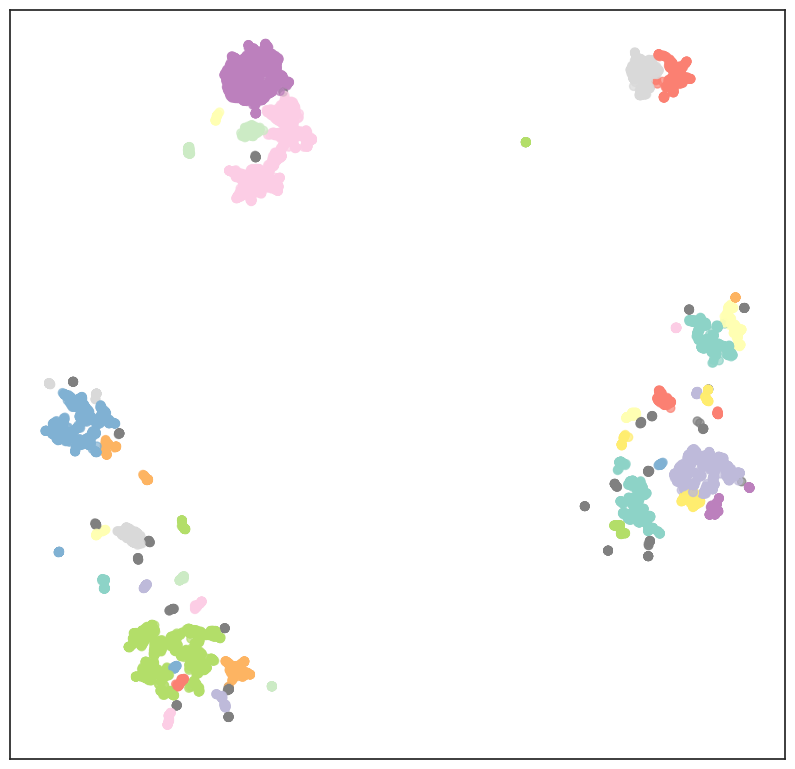

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [47]:
# Calculate clusters without specifying the number of clusters; DBSCAN determines this based on 'eps'
eps=0.25
target_data_clustered = calculate_clusters("TYK2", tyk2_data, eps)

# Plot the clusters
plot_clusters("TYK2", target_data_clustered,eps)


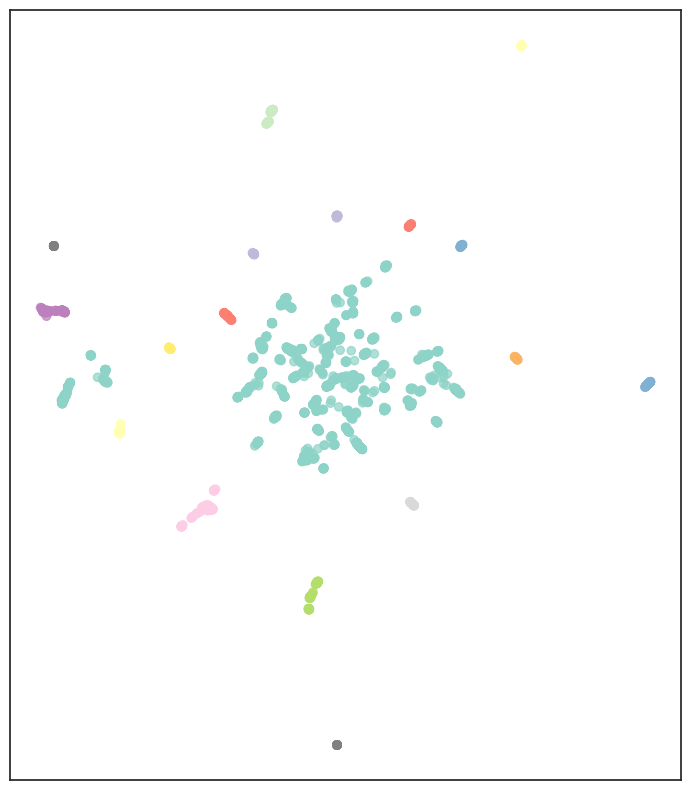

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [53]:
# Calculate clusters without specifying the number of clusters; DBSCAN determines this based on 'eps'
eps=1.5
target_data_clustered = calculate_clusters("D2R", d2r_data, eps)

# Plot the clusters
plot_clusters("D2R", target_data_clustered,eps)


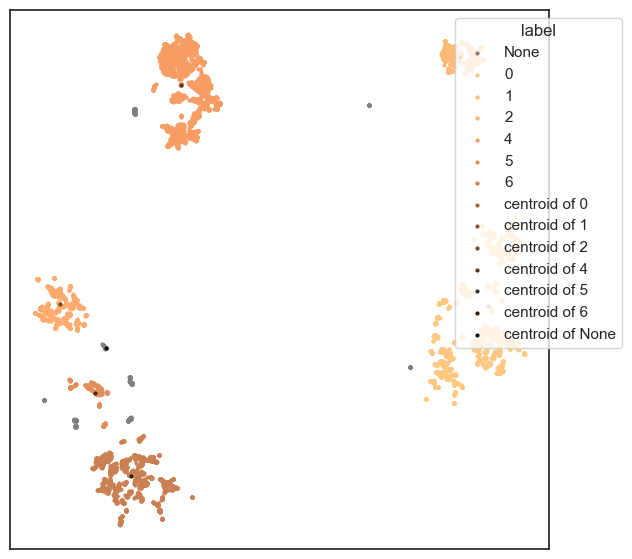

In [11]:
plot_clusters("TYK2", tyk2_clust, highlight_cluster=None)

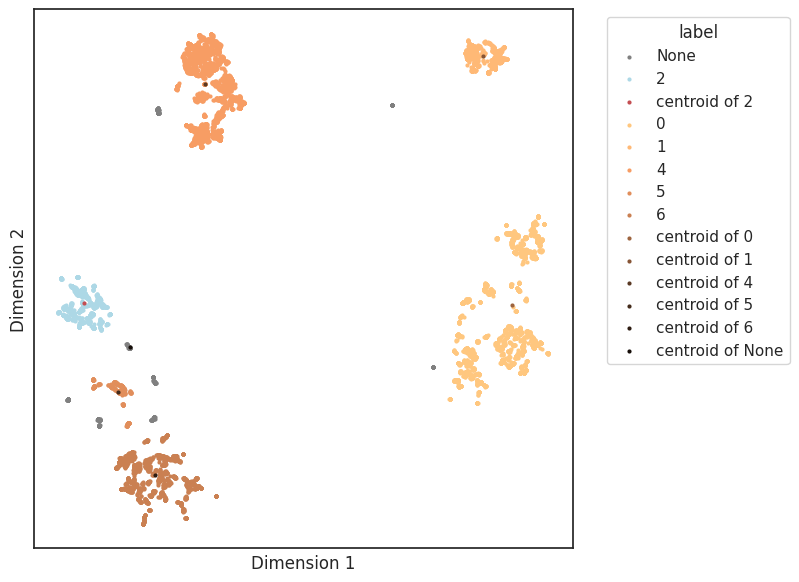

In [5]:
plot_clusters("TYK2", tyk2_clust, highlight_cluster=2)

In [ ]:
centroids = get_centroids(tyk2_clust)
centroids

In [6]:
centroids = get_centroids(tyk2_clust)
centroids

,SMILES,affinity,target,top_2p,top_5p,fps,label
3796,Cc1cc(ccc1C(=O)Nc2ccnc(c2)Nc3cncc(n3)CO)Cl,5.691267,TYK2,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",centroid of 4
4734,Cc1ccc(c(c1)OC)C(=O)Nc2ccnc(c2)NC(=O)C3CC3,5.044070,TYK2,False,False,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",centroid of 6
7117,c1cc(c(c(c1)F)C(=O)Nc2ccnc(c2)NCC3CC3)N,3.176941,TYK2,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",centroid of 2
8801,c1cc(ccc1C(=O)Nc2ccnc(c2)NC(=O)C3COC3)N,6.879313,TYK2,False,False,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",centroid of 5
9300,c1ccc(cc1)C(=O)Nc2cc(ncc2F)Nc3cc(ccn3)CO,7.946470,TYK2,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",centroid of 1
9404,c1ccc(cc1)CNC(=O)Nc2cc(c(cn2)F)NC(=O)c3cccc(c3)Cl,7.265984,TYK2,False,False,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",centroid of 0


In [14]:
centroids['SMILES']

585     CCC1C(=O)N(C(=O)N1)Cc2cc3c(s2)c(ncn3)c4cc(cc(c...
1196    COc1ccc(cc1)n2ccc3c2ncn(c3=O)CC4(CCN(CC4)C(=O)...
2239    Cc1cc(cc(c1OC2CNCC2NC(=O)C)c3ccnc4c3sc(c4)CN5C...
2251    Cc1cc(cc(c1OC2CNCCC2C)c3ccnc4c3sc(c4)COc5nc(=O...
2561    Cc1ccc(cn1)c2nc(c(s2)C(=O)N3CCC(C(C3)c4ccccc4)...
2999    Cn1c2c(cn1)c(=O)n(cn2)CC3(CCN(CC3)C(=O)CC(c4cc...
4173    c1ccc(cc1)C2CNCCC2C(=O)N3CCC(CC3)(Cn4cnc(c(c4=...
4266    c1ccc(cc1)COC(=O)NC(Cc2c[nH]c3c2cccc3)C(=O)NC4...
Name: SMILES, dtype: object

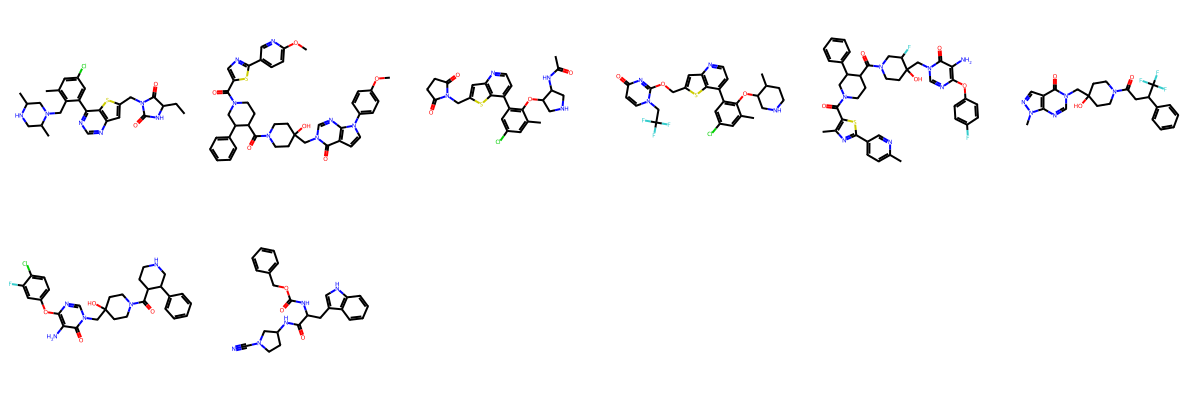

In [15]:
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import Draw

mols = [MolFromSmiles(smi) for smi in centroids.SMILES]
Draw.MolsToGridImage(mols, molsPerRow=6)

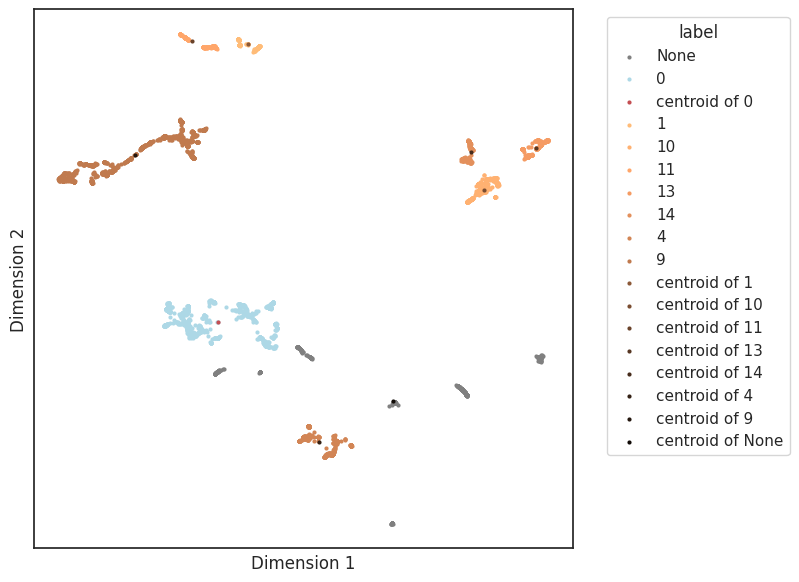

In [52]:
plot_clusters("USP7", usp7_clust, highlight_cluster=0)

In [17]:
centroids = get_centroids(usp7_clust)
centroids

,SMILES,affinity,target,top_2p,top_5p,fps,label
585,CCC1C(=O)N(C(=O)N1)Cc2cc3c(s2)c(ncn3)c4cc(cc(c...,11.301030,USP7,False,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",centroid of 13
1196,COc1ccc(cc1)n2ccc3c2ncn(c3=O)CC4(CCN(CC4)C(=O)...,10.913640,USP7,False,False,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...",centroid of 9
2239,Cc1cc(cc(c1OC2CNCC2NC(=O)C)c3ccnc4c3sc(c4)CN5C...,8.259637,USP7,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",centroid of 10
2251,Cc1cc(cc(c1OC2CNCCC2C)c3ccnc4c3sc(c4)COc5nc(=O...,9.301030,USP7,False,False,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",centroid of 14
2561,Cc1ccc(cn1)c2nc(c(s2)C(=O)N3CCC(C(C3)c4ccccc4)...,10.970616,USP7,False,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",centroid of 11
2999,Cn1c2c(cn1)c(=O)n(cn2)CC3(CCN(CC3)C(=O)CC(c4cc...,8.259637,USP7,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",centroid of 0
4173,c1ccc(cc1)C2CNCCC2C(=O)N3CCC(CC3)(Cn4cnc(c(c4=...,9.634512,USP7,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",centroid of 1
4266,c1ccc(cc1)COC(=O)NC(Cc2c[nH]c3c2cccc3)C(=O)NC4...,8.795880,USP7,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",centroid of 4


In [53]:
print(centroids[centroids['label']=='centroid of 0']['SMILES'])

2999    Cn1c2c(cn1)c(=O)n(cn2)CC3(CCN(CC3)C(=O)CC(c4ccccc4)C(F)(F)F)O
Name: SMILES, dtype: object


In [45]:
import pandas as pd

# Set the display option to not truncate
pd.set_option('display.max_colwidth', None)

print(centroids[centroids['label']=='centroid of 10']['SMILES'].iloc[0])


Cc1cc(cc(c1OC2CNCC2NC(=O)C)c3ccnc4c3sc(c4)CN5C(=O)CCC5=O)Cl


In [30]:
centroids['SMILES']['label']=='centroid of 9'

KeyError: 'label'

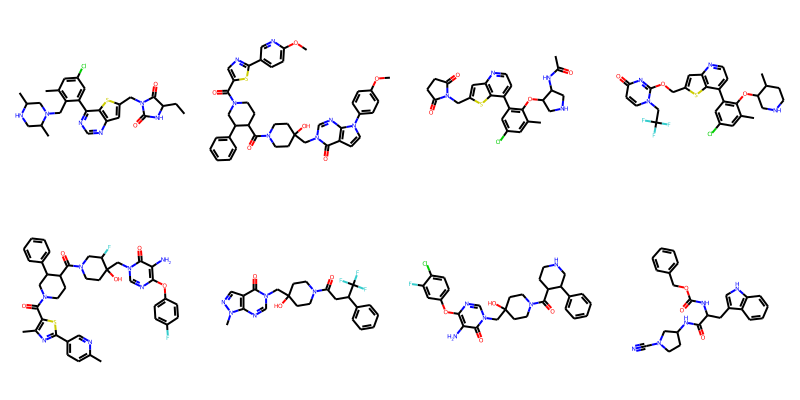

In [160]:
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import Draw

mols = [MolFromSmiles(smi) for smi in centroids.SMILES]
Draw.MolsToGridImage(mols, molsPerRow=4)